In [1]:
!pip install torch
!pip install torchmetrics
!pip install matplotlib

In [1]:
# Handling Model
import copy
import os

import torch

from torchmetrics import Dice

import matplotlib.pyplot as plt

from dataset import ChestXRaysSegmentationDataset

Dataset

In [2]:
# define path to images
image_path = './chest_xray/images'
mask_path = './chest_xray/masks'
size = 256
# get dataset, need resize to be divisible by 16 for all 4 max pools, to keep 
dataset = ChestXRaysSegmentationDataset(image_path,mask_path,size)
augmented_dataset = ChestXRaysSegmentationDataset(image_path,mask_path,size,True)

100%|██████████| 704/704 [00:00<00:00, 1458888.35it/s]


In [3]:
def splitDataset(augmented_dataset):
    # Split dataset into a test and train datasets
    subsets = []

    # Get a size of fifth of dataset
    test_split = (int)(len(augmented_dataset) / 5)

    # Split fifth of dataset into test dataset
    remaining = len(augmented_dataset) - test_split
    test_dataset, remaining_dataset  = torch.utils.data.random_split(augmented_dataset, [test_split, remaining])

    # Get size of 1/10 of dataset
    split = (int)(len(augmented_dataset) / 10)

    # Split the remaining into 1/10 of original dataset, for training set
    while remaining >= split:
        remaining = len(remaining_dataset) - split
        split_dataset, remaining_dataset  = torch.utils.data.random_split(remaining_dataset, [split, remaining])
        subsets.append(split_dataset)
        
    return subsets, test_dataset

Training Method

In [4]:
# Define the training function
def train_fn(model, loss_fn, dataloader, optimizer, device = 'cpu'):
    
    model.train()

    avg_loss = 0
    for i, (X, y) in enumerate(dataloader):
        # Get data
        X_train, y_train = X.to(device), y.to(device)  
        # Get Output
        output = model(X_train).to(device)
        # Compute loss
        loss = loss_fn(output, y_train)
        avg_loss += loss.item()
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(dataloader)
    
        

Test Method

In [5]:
def test_fn(model, loss_fn, dice, dataloader, device = 'cpu'):
    model.eval()
    test_loss = 0
    test_dice = 0
    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fn(output, y)
            test_loss += loss.item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(dataloader)
    test_dice /= len(dataloader)
    
    return test_loss, test_dice

Save Model Method

In [6]:
def saveModel(model, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name)
    # Save model
    torch.save(model, path)
    print(f"{name} saved succesfully")

Training

In [7]:
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

BATCH_SIZE = 128
num_workers = 8

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = 0.01
loss_fn = torch.nn.BCELoss()


dice = Dice(average = 'micro', num_classes = 2, threshold = 0.5).to(device)

In [8]:
SPLIT_TEST_DICE = [0,0,0,0,0,0,0,0]
SPLIT_TEST_LOSS = [0,0,0,0,0,0,0,0]

# Number of times to run experiment
iterations = 4

# Threshold loss to stop training model
threshold_loss = 0.3

# Run experiment multiple times
for j in range(iterations):
    # Get test dataset and train splits
    subsets, test_dataset = splitDataset(augmented_dataset)
    for i in range(len(subsets)):
        # Initialize model, optimizer, and learning rate scheduler
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=64, pretrained=False, trust_repo=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
        #name = f'UNet|Split:{(i+1)/10}|Iter:{j}'
        
        # Create train dataset for split
        train_dataset = torch.utils.data.ConcatDataset(subsets[:i+1])
        
        # Load datasets into dataloaders
        if i == 0: # Error when loading single dataset in concat into loader, so seperate case
            train_dataloader = torch.utils.data.DataLoader(dataset=subsets[i], num_workers = num_workers, shuffle =True)
        else:
            train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, num_workers = num_workers, shuffle =True)
        test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, num_workers = num_workers, shuffle =False)
        
        # Initialize loss and previous loss
        loss = float("inf")
        best_loss = float("inf")
        # Train model until it reaches threshold loss
        while(loss > threshold_loss):
            
            # Compute training loss
            loss = train_fn(model, loss_fn, train_dataloader, optimizer, device)
            # Update best loss if new loss is less than it
            if best_loss > loss:
                best_loss = loss
            # Adjust learning rate if new loss is worse than best loss
            else:
                lr_scheduler.step()
        # Check accuracy and loss on test set
        test_loss , test_dice = test_fn(copy.deepcopy(model), loss_fn, dice, test_dataloader, device)
        # Save model
        #saveModel(model,name)
        # Save test loss and dice score for plotting later
        SPLIT_TEST_DICE[i] += test_dice
        SPLIT_TEST_LOSS[i] += test_loss
# Take average of experiments
for i in range(len(subsets)):
    SPLIT_TEST_DICE[i] /= iterations
    SPLIT_TEST_LOSS[i] /= iterations
    

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


(2388, 2407, 3)
(2571, 2430, 3)
(3001, 2674, 3)
(2931, 3000, 3)
(2995, 2990, 3)
(2967, 3000, 3)
(2942, 2427, 3)
(3, 4892, 4020)
(3, 4020, 4892)
(2403, 2420, 3)
(2988, 2619, 3)
(2603, 2516, 3)
(2457, 2997, 3)
(2989, 2993, 3)
(2928, 2464, 3)
(3, 4892, 4020)

IndexError: Caught IndexError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 362, in __getitems__
    return self.dataset.__getitems__([self.indices[idx] for idx in indices])  # type: ignore[attr-defined]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/notebooks/dataset.py", line 57, in __getitem__
    true_img = self.reshape(img_rescaled).to(torch.float32)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/notebooks/dataset.py", line 31, in reshape
    for i in range(img.shape[2]):
                   ~~~~~~~~~^^^
IndexError: tuple index out of range



(3001, 2990, 3)
(2582, 2316, 3)
(2931, 3000, 3)
(2944, 2980, 3)
(2947, 3000, 3)
(3, 4892, 4020)


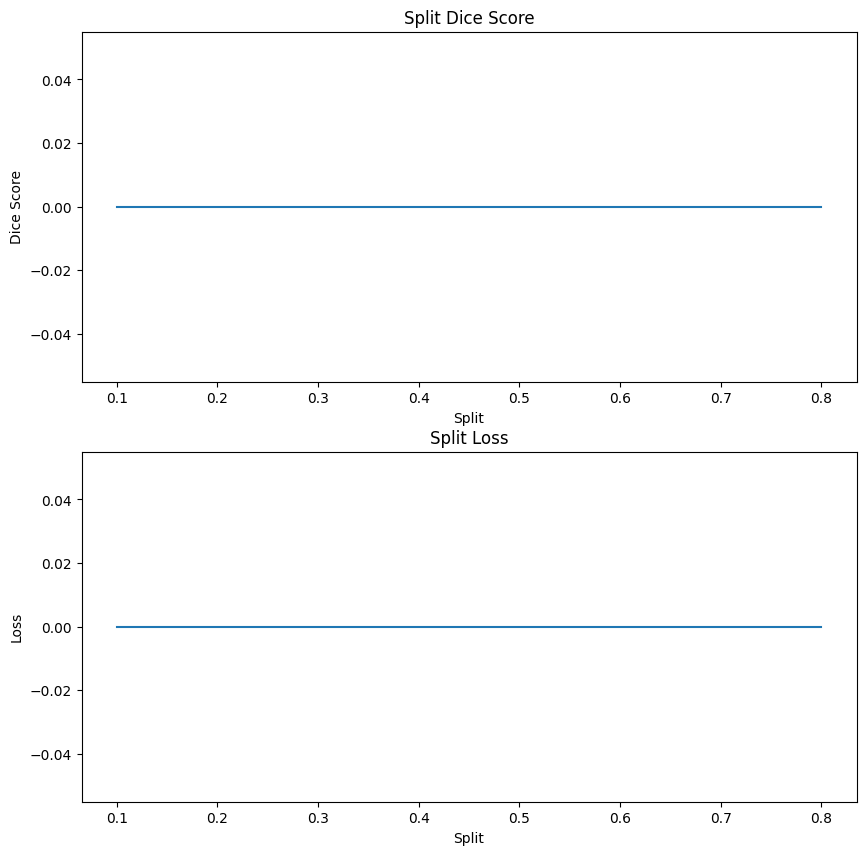

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot test loss and dice
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

fig, ax = plt.subplots(2,1, figsize=(10,10))
plt.figure()
# Plot dice scores
ax[0].plot(SPLIT_TEST_DICE, label = "Split Dice Score")
ax[0].set_title("Split Dice Score")
ax[0].set_xlabel("Split")
ax[0].set_ylabel("Dice Score")
ax[0].set_xticks(range(len(splits)))
ax[0].set_xticklabels(splits)
# Plot losses
ax[1].plot(SPLIT_TEST_LOSS, label = "Split Loss")
ax[1].set_title("Split Loss")
ax[1].set_xlabel("Split")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(len(splits)))
ax[1].set_xticklabels(splits)

plt.show()